In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data/labor_data"
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output/data"

In [6]:
data = pd.read_csv(f"{output_dir}/clean_stocks.csv")

In [7]:
select = ['date', 'P_12m_change', "P_1m_change_annualize", "P_3m_change_annualize", "V_rate", "U_rate", "tightness"]
df = data[select]
df= df[select].dropna()

df['U_rate_square'] = df['U_rate'] ** 2

In [8]:
X = df[['U_rate','U_rate_square', 'P_12m_change']]
#X = df[['U_rate','U_rate_square', 'P_4m_change_annualize']]
y = df['tightness']

# Add a constant to the independent variables matrix (intercept)
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              tightness   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     1390.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        10:27:53   Log-Likelihood:                 425.02
No. Observations:                 882   AIC:                            -842.0
Df Residuals:                     878   BIC:                            -822.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.7765      0.050     55.143

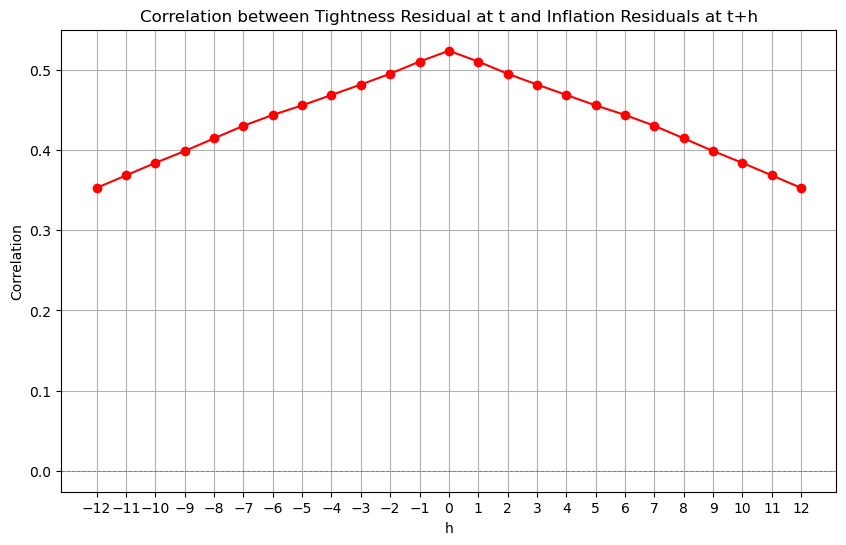

In [16]:

# Ensure your DataFrame has the right columns
tightness_col = 'tightness'  
inflation_col = "P_12m_change"
#inflation_col = 'P_3m_change_annualize'  
unemployment_col = 'U_rate'  

# Function to get residuals from regression
def get_residuals(df, y_col, x_col):
    X = sm.add_constant(df[x_col])  # Add constant term for intercept
    model = sm.OLS(df[y_col], X).fit()
    return model.resid

# Get residuals for tightness and inflation
df.loc[:, 'tightness_resid'] = get_residuals(df, tightness_col, ['U_rate' , "U_rate_square"])
df.loc[:, 'inflation_resid'] = get_residuals(df, inflation_col, ['U_rate' , "U_rate_square"])

# Create an empty list to hold correlation values for residuals
correlations_resid = []

# Calculate correlations for h from -12 to 12 using residuals
for h in range(-12, 13):
    if h < 0:
        correlation = df['tightness_resid'].corr(df['inflation_resid'].shift(-h))
    else:
        correlation = df['tightness_resid'].corr(df['inflation_resid'].shift(h))
    
    correlations_resid.append(correlation)

# Create a range of h values for the x-axis
h_values = np.arange(-12, 13)

# Plot the correlations of the residuals
plt.figure(figsize=(10, 6))
plt.plot(h_values, correlations_resid, marker='o', linestyle='-', color='r')
plt.title('Correlation between Tightness Residual at t and Inflation Residuals at t+h')
plt.xlabel('h')
plt.ylabel('Correlation')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
plt.grid()
plt.xticks(h_values)  # Set x-ticks to show all h values
plt.show()

<Figure size 1000x500 with 0 Axes>

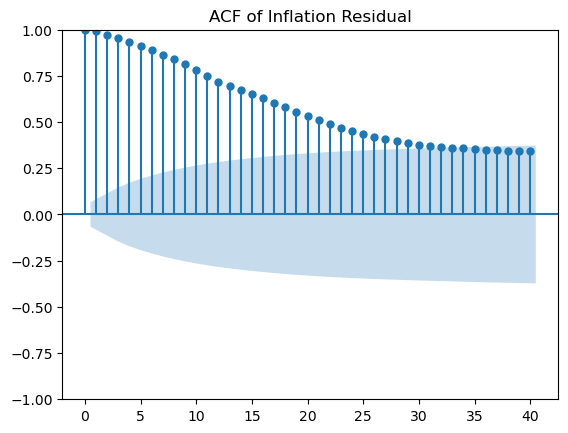

C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x500 with 0 Axes>

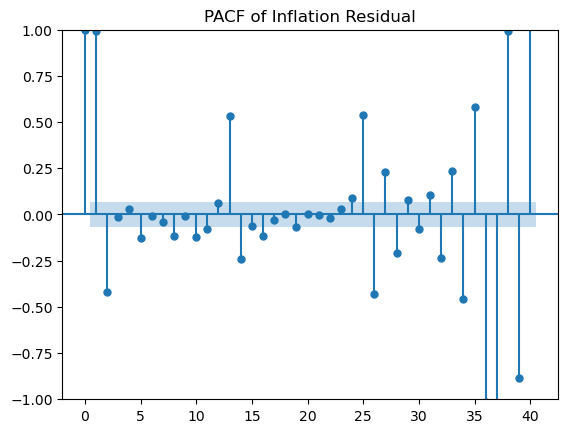

In [17]:
# Plot ACF
plt.figure(figsize=(10,5))
plot_acf(df['inflation_resid'], lags=40)
plt.title("ACF of Inflation Residual")
plt.show()

# Plot PACF
plt.figure(figsize=(10,5))
plot_pacf(df['inflation_resid'], lags=40)
plt.title("PACF of Inflation Residual")
plt.show()

<Figure size 1000x500 with 0 Axes>

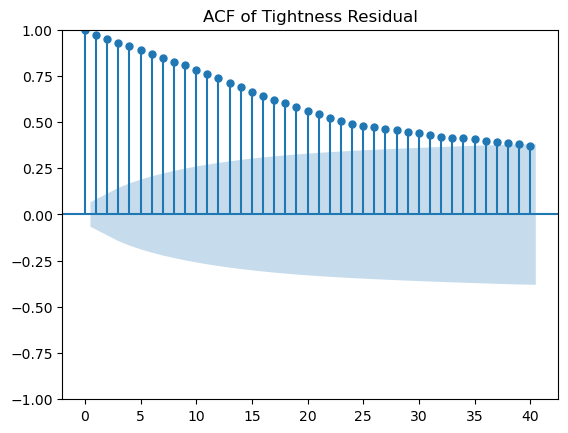

C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x500 with 0 Axes>

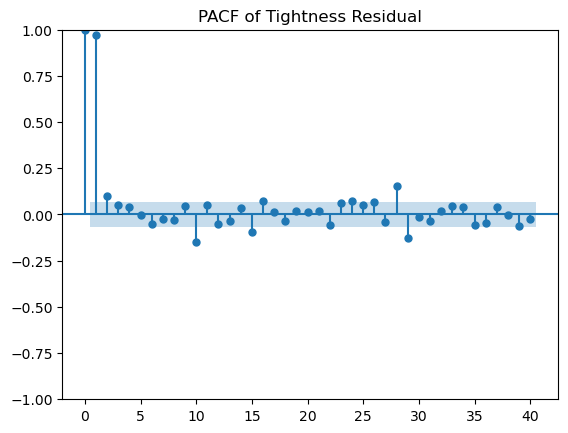

In [14]:
# Plot ACF
plt.figure(figsize=(10,5))
plot_acf(df['tightness_resid'], lags=40)
plt.title("ACF of Tightness Residual")
plt.show()

# Plot PACF
plt.figure(figsize=(10,5))
plot_pacf(df['tightness_resid'], lags=40)
plt.title("PACF of Tightness Residual")
plt.show()

In [20]:
tightness_model = sm.tsa.ARIMA(df['tightness_resid'], order=(1, 0, 0)).fit()

# Print the results for tightness
print("Tightness Residual AR(1) Model:")
print(tightness_model.summary())

tightness_ar1_residuals = tightness_model.resid

Tightness Residual AR(1) Model:
                               SARIMAX Results                                
Dep. Variable:        tightness_resid   No. Observations:                  870
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1518.022
Date:                Thu, 10 Oct 2024   AIC                          -3030.044
Time:                        11:58:36   BIC                          -3015.739
Sample:                             0   HQIC                         -3024.571
                                - 870                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.76e-06      0.050   3.53e-05      1.000      -0.098       0.098
ar.L1          0.9706      0.004    230.447      0.000       0.962       0.979
sigma2         0.001

C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
# Model for Inflation (SARIMA(2, 0, 0)(2, 0, 0, 12) process)
inflation_model = sm.tsa.SARIMAX(df['inflation_resid'], 
                                 order=(2, 0, 0), 
                                 seasonal_order=(2, 0, 0, 12)).fit()

# Print the results for inflation
print("\nInflation Residual SAR(2,2) Model:")
print(inflation_model.summary())

inflation_sar_residuals = inflation_model.resid

C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Inflation Residual SAR(2,2) Model:
                                     SARIMAX Results                                      
Dep. Variable:                    inflation_resid   No. Observations:                  870
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -179.214
Date:                            Thu, 10 Oct 2024   AIC                            368.428
Time:                                    11:58:56   BIC                            392.270
Sample:                                         0   HQIC                           377.550
                                            - 870                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4658      0.024     62.138      0.000       1.420       1.512

In [22]:
df['tightness_ar1_residuals'] = tightness_ar1_residuals
df['inflation_sar_residuals'] = inflation_sar_residuals

Length of correlations_resid: 25


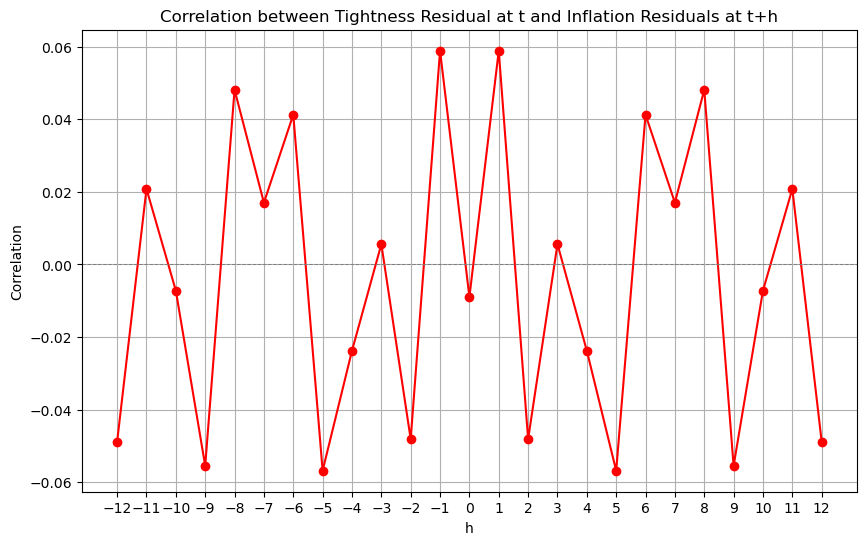

In [27]:
# Initialize the correlations list
correlations_resid = []

# Calculate correlations for each h
for h in range(-12, 13):
    if h < 0:
        correlation = df['tightness_ar1_residuals'].corr(df['inflation_sar_residuals'].shift(-h))
    else:
        correlation = df['tightness_ar1_residuals'].corr(df['inflation_sar_residuals'].shift(h))
    
    # Append the correlation, handling NaN values
    correlations_resid.append(correlation)

# Ensure the length of correlations_resid is 25
print("Length of correlations_resid:", len(correlations_resid))

# Create a range of h values for the x-axis
h_values = np.arange(-12, 13)

# Plot the correlations of the residuals
plt.figure(figsize=(10, 6))
plt.plot(h_values, correlations_resid, marker='o', linestyle='-', color='r')
plt.title('Correlation between Tightness Residual at t and Inflation Residuals at t+h')
plt.xlabel('h')
plt.ylabel('Correlation')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
plt.grid()
plt.xticks(h_values)  # Set x-ticks to show all h values
plt.show()

In [28]:
# Create lagged variables for tightness residuals (up to 12 lags)
for lag in range(1, 13):
    df[f'tightness_resid_lag_{lag}'] = df['tightness_ar1_residuals'].shift(lag)

# Create lagged variables for inflation residuals (up to 12 lags)
for lag in range(1, 13):
    df[f'inflation_resid_lag_{lag}'] = df['inflation_sar_residuals'].shift(lag)

# Drop rows with NaN values resulting from lagging
df = df.dropna()

# Define the dependent variable and independent variables for inflation -> tightness
X_inflation_to_tightness = df[[f'inflation_resid_lag_{lag}' for lag in range(1, 13)]]
y_tightness = df['tightness_resid']

# Add a constant for the intercept
X_inflation_to_tightness = sm.add_constant(X_inflation_to_tightness)

# Run the regression for inflation predicting tightness
model_inflation_to_tightness = sm.OLS(y_tightness, X_inflation_to_tightness).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

# Print the summary of the regression results
print("Inflation predicting Tightness:")
print(model_inflation_to_tightness.summary())

# Define the dependent variable and independent variables for tightness -> inflation
X_tightness_to_inflation = df[[f'tightness_resid_lag_{lag}' for lag in range(1, 13)]]
y_inflation = df['inflation_resid']

# Add a constant for the intercept
X_tightness_to_inflation = sm.add_constant(X_tightness_to_inflation)

# Run the regression for tightness predicting inflation
model_tightness_to_inflation = sm.OLS(y_inflation, X_tightness_to_inflation).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

# Print the summary of the regression results
print("\nTightness predicting Inflation:")
print(model_tightness_to_inflation.summary())

Inflation predicting Tightness:
                            OLS Regression Results                            
Dep. Variable:        tightness_resid   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     1.612
Date:                Thu, 10 Oct 2024   Prob (F-statistic):             0.0831
Time:                        12:15:22   Log-Likelihood:                 309.90
No. Observations:                 834   AIC:                            -593.8
Df Residuals:                     821   BIC:                            -532.4
Df Model:                          12                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [13]:
import pandas as pd
import statsmodels.api as sm

# Create lagged variables for tightness residuals (up to 12 lags)
for lag in range(1, 13):
    df[f'tightness_resid_lag_{lag}'] = df['tightness_resid'].shift(lag)

# Create lagged variables for inflation residuals (up to 12 lags)
for lag in range(1, 13):
    df[f'inflation_resid_lag_{lag}'] = df['inflation_resid'].shift(lag)

# Drop rows with NaN values resulting from lagging
df = df.dropna()

### 1. Regression: Inflation predicting Tightness (including lags of tightness as predictors)
# Define the independent variables (inflation lags + tightness lags) and the dependent variable (tightness)
X_inflation_to_tightness = df[[f'inflation_resid_lag_{lag}' for lag in range(1, 13)] + 
                              [f'tightness_resid_lag_{lag}' for lag in range(1, 13)]]
y_tightness = df['tightness_resid']

# Add a constant for the intercept
X_inflation_to_tightness = sm.add_constant(X_inflation_to_tightness)

# Run the regression for inflation predicting tightness
model_inflation_to_tightness = sm.OLS(y_tightness, X_inflation_to_tightness).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

# Print the summary of the regression results
print("Inflation predicting Tightness (with lagged tightness residuals):")
print(model_inflation_to_tightness.summary())

### 2. Regression: Tightness predicting Inflation (including lags of inflation as predictors)
# Define the independent variables (tightness lags + inflation lags) and the dependent variable (inflation)
X_tightness_to_inflation = df[[f'tightness_resid_lag_{lag}' for lag in range(1, 13)] + 
                              [f'inflation_resid_lag_{lag}' for lag in range(1, 13)]]
y_inflation = df['inflation_resid']

# Add a constant for the intercept
X_tightness_to_inflation = sm.add_constant(X_tightness_to_inflation)

# Run the regression for tightness predicting inflation
model_tightness_to_inflation = sm.OLS(y_inflation, X_tightness_to_inflation).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

# Print the summary of the regression results
print("\nTightness predicting Inflation (with lagged inflation residuals):")
print(model_tightness_to_inflation.summary())


Inflation predicting Tightness (with lagged tightness residuals):
                            OLS Regression Results                            
Dep. Variable:        tightness_resid   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     752.2
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        10:44:04   Log-Likelihood:                 1542.1
No. Observations:                 870   AIC:                            -3034.
Df Residuals:                     845   BIC:                            -2915.
Df Model:                          24                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

In [207]:

# Create lagged variables for tightness residuals (up to 12 lags)
for lag in range(1, 13):
    df[f'tightness_resid_lag_{lag}'] = df['tightness_resid'].shift(lag)

# Create lagged variables for inflation residuals (up to 12 lags)
for lag in range(1, 13):
    df[f'inflation_resid_lag_{lag}'] = df['inflation_resid'].shift(lag)

# Drop rows with NaN values resulting from lagging
df = df.dropna()

# Define the dependent variable and independent variables for inflation -> tightness
X_inflation_to_tightness = df[[f'inflation_resid_lag_{lag}' for lag in range(1, 13)]]
y_tightness = df['tightness_resid']

# Add a constant for the intercept
X_inflation_to_tightness = sm.add_constant(X_inflation_to_tightness)

# Run the regression for inflation predicting tightness
model_inflation_to_tightness = sm.OLS(y_tightness, X_inflation_to_tightness).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

# Print the summary of the regression results
print("Inflation predicting Tightness:")
print(model_inflation_to_tightness.summary())

# Define the dependent variable and independent variables for tightness -> inflation
X_tightness_to_inflation = df[[f'tightness_resid_lag_{lag}' for lag in range(1, 13)]]
y_inflation = df['inflation_resid']

# Add a constant for the intercept
X_tightness_to_inflation = sm.add_constant(X_tightness_to_inflation)

# Run the regression for tightness predicting inflation
model_tightness_to_inflation = sm.OLS(y_inflation, X_tightness_to_inflation).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

# Print the summary of the regression results
print("\nTightness predicting Inflation:")
print(model_tightness_to_inflation.summary())

Inflation predicting Tightness:
                            OLS Regression Results                            
Dep. Variable:        tightness_resid   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     9.633
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           1.03e-17
Time:                        10:14:06   Log-Likelihood:                 392.30
No. Observations:                 834   AIC:                            -758.6
Df Residuals:                     821   BIC:                            -697.2
Df Model:                          12                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [208]:

# Perform Granger causality test
# You can test for both directions
max_lag = 3  # Number of lags to test
gc_test_inflation_to_tightness = grangercausalitytests(df[['tightness_resid', 'inflation_resid']], max_lag, verbose=True)
gc_test_tightness_to_inflation = grangercausalitytests(df[['inflation_resid', 'tightness_resid']], max_lag, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0385  , p=0.8445  , df_denom=830, df_num=1
ssr based chi2 test:   chi2=0.0387  , p=0.8441  , df=1
likelihood ratio test: chi2=0.0387  , p=0.8441  , df=1
parameter F test:         F=0.0385  , p=0.8445  , df_denom=830, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8815  , p=0.1530  , df_denom=827, df_num=2
ssr based chi2 test:   chi2=3.7858  , p=0.1506  , df=2
likelihood ratio test: chi2=3.7772  , p=0.1513  , df=2
parameter F test:         F=1.8815  , p=0.1530  , df_denom=827, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8733  , p=0.0354  , df_denom=824, df_num=3
ssr based chi2 test:   chi2=8.6931  , p=0.0337  , df=3
likelihood ratio test: chi2=8.6479  , p=0.0344  , df=3
parameter F test:         F=2.8733  , p=0.0354  , df_denom=824, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.5261 , p=0.0000  

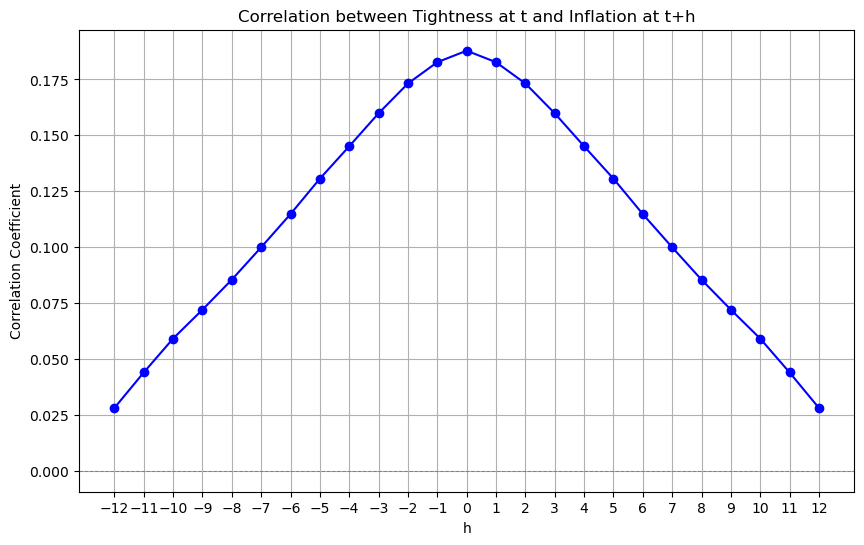

In [145]:
tightness_col = 'tightness'       # Replace with the actual column name for tightness
#inflation_col = 'P_12m_change'    # Replace with the actual column name for inflation
inflation_col = "P_4m_change_annualize"
# Create an empty list to hold correlation values
correlations = []

# Calculate correlations for h from -12 to 12
for h in range(-12, 13):
    if h < 0:
        correlation = df[tightness_col].corr(df[inflation_col].shift(-h))
    else:
        correlation = df[tightness_col].corr(df[inflation_col].shift(h))
    
    correlations.append(correlation)

# Create a range of h values for the x-axis
h_values = np.arange(-12, 13)

# Plot the correlations
plt.figure(figsize=(10, 6))
plt.plot(h_values, correlations, marker='o', linestyle='-', color='b')
plt.title('Correlation between Tightness at t and Inflation at t+h')
plt.xlabel('h')
plt.ylabel('Correlation Coefficient')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
plt.grid()
plt.xticks(h_values)  # Set x-ticks to show all h values
plt.show()
